In [1]:
import sys
import numpy as np
import tqdm
from astropy.constants import m_p, M_sun, k_B, G
import astropy.units as u
from plotting_setup import *

sys.path.append('../pipeline_scripts/')
from pipeline_2D import to_osyris_ivs
from pipeline_main import sink_positions, serialize_directory, sinks, true_sinks, pipeline
from pipeline_1D import to_1D

core_data = {}
initial_sn = [158, 222, 176, 212, 235, 341, 401, 403, 445]



In [2]:
data = pipeline(snap = 512, run = 'sink13fmr05', sink_id=13)
data.recalc_L()
data.calc_trans_xyz()

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:05<00:00, 719.99it/s]


Converged mean angular momentum vector after 0 iteration(s)
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:01<00:00, 2998.11it/s]


Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:01<00:00, 2331.86it/s]


Disk size: 63.0 au


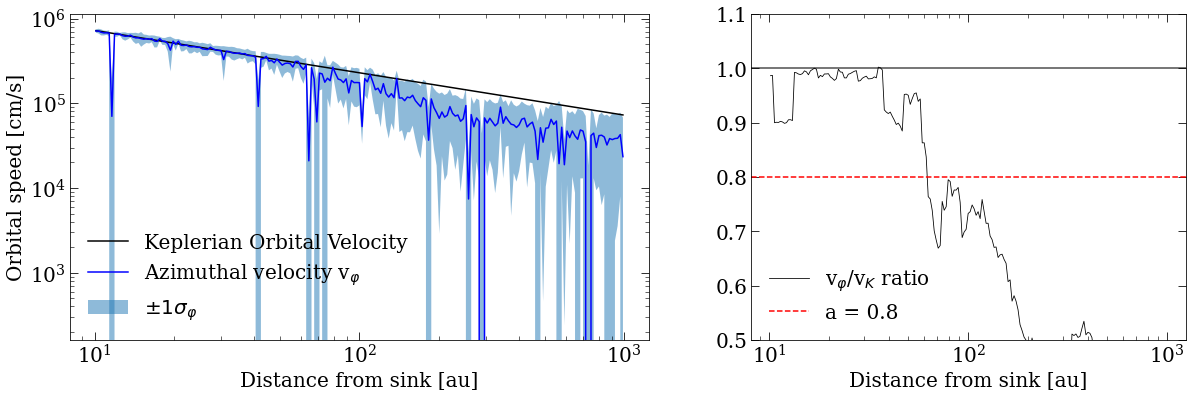

In [3]:
data.calc_disksize()

#plt.savefig(save_folder + 'keplerian_disk_13', facecolor='w', dpi = 500, bbox_inches='tight')

Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 199/199 [00:05<00:00, 34.27it/s]


Validating fit...


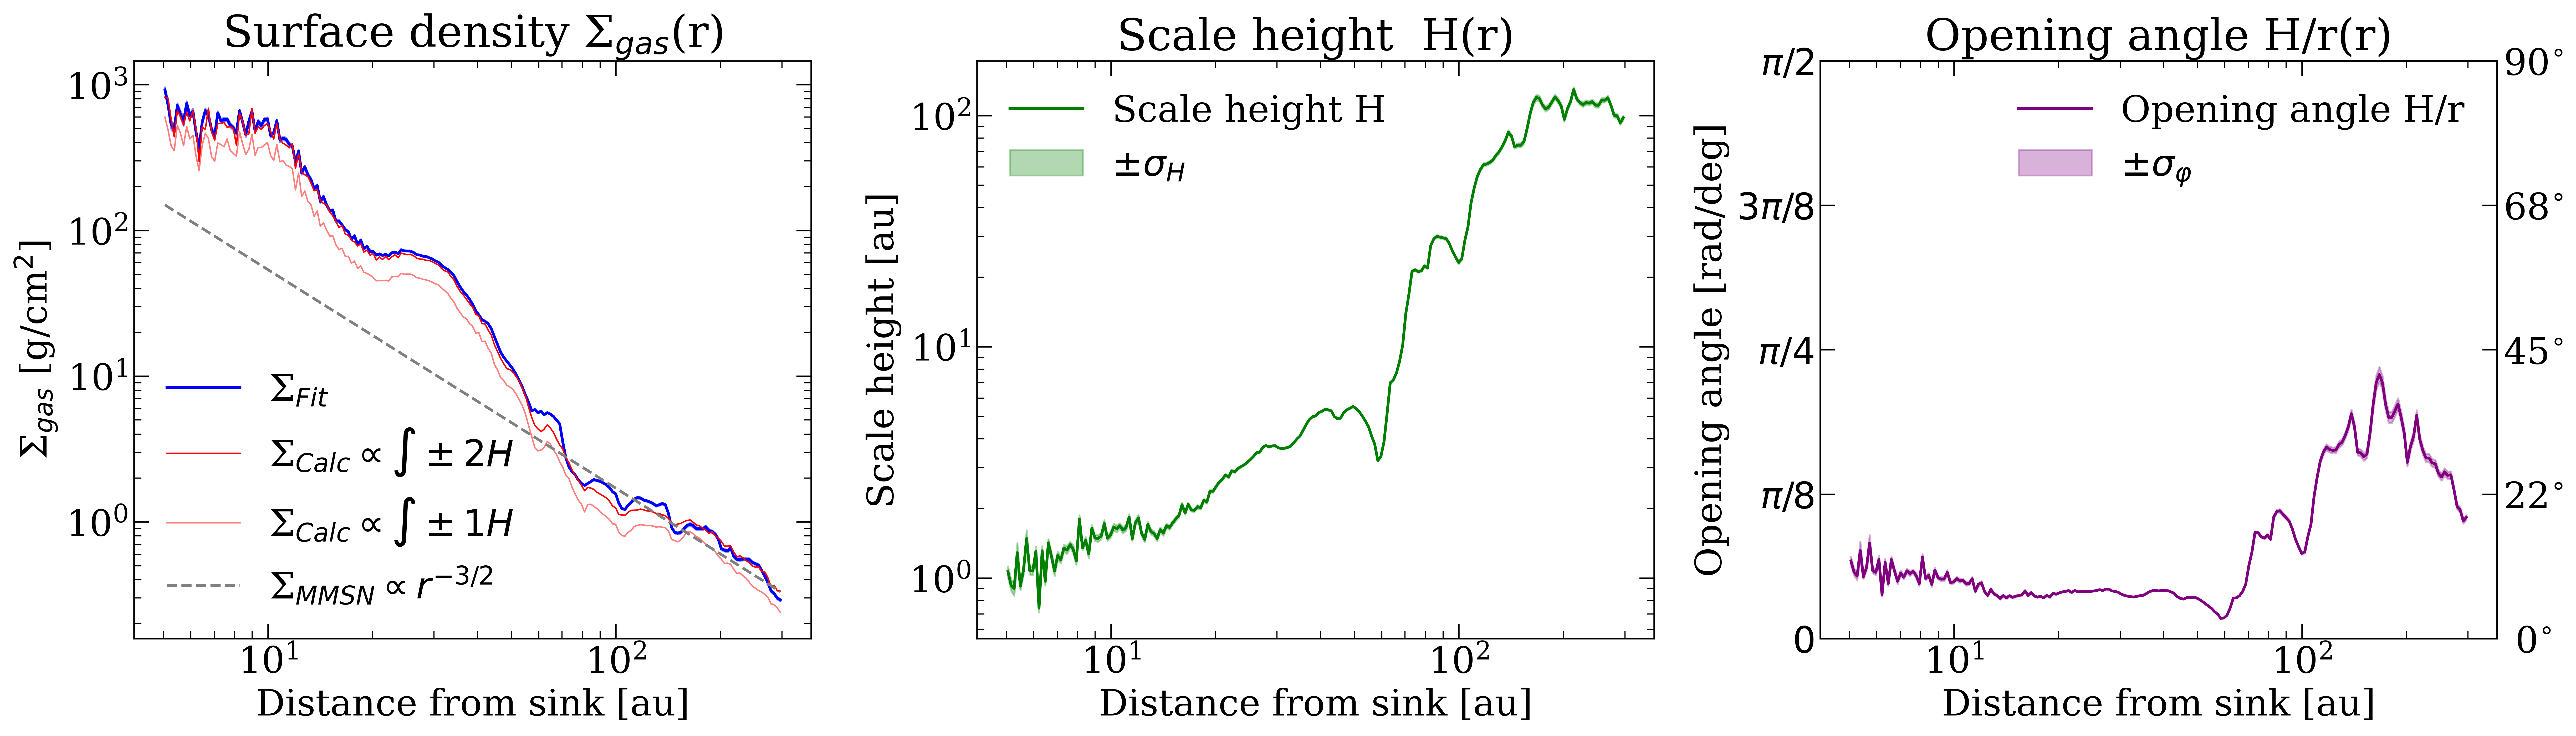

In [4]:
data.to_1D(r_in = 5, r_out=300, Nr=200, dpi = 500)
plt.savefig(save_folder + 'surface_density', facecolor='w', dpi = 500, bbox_inches='tight')

In [5]:
(data.H_1D[:,0] / (data.r_1D * data.au_length))[(data.r_1D * data.au_length) < 60].mean()

0.1374990097439184

In [6]:
1 / 0.14, 1/7

(7.142857142857142, 0.14285714285714285)

In [7]:
for p in tqdm.tqdm(data.sn.patches):
    p.vx, p.vy, p.vz = p.trans_vrel
    p.c_s = np.sqrt(p.γ * p.P / p.var('d'))
    p.Ω = p.vφ / p.cyl_R

 44%|████▍     | 1833/4165 [00:00<00:00, 5547.25it/s]

100%|██████████| 4165/4165 [00:00<00:00, 5626.39it/s]


In [8]:
res = 1000; width = 200 
X, Y = np.linspace(-width //2 ,width //2,res), np.linspace(-width //2, width //2,res)
variable = ['c_s', 'Ω', 'γ', 'vx', 'vy']

In [9]:
data.to_osyris_ivs(variables=variable, data_name = 'mass_weighted', view = width, resolution=res, weights='mass')

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/1411 [00:00<?, ?it/s]

100%|██████████| 1411/1411 [00:06<00:00, 213.95it/s]


Setting up Osyris data structure


In [10]:
data.to_osyris_ivs(variables=['c_s'], data_name = 'volume_weighted', view = width, resolution=res, weights='volume')

Looping over DISPATCH data to extract data at highest level


  5%|▍         | 66/1411 [00:00<00:02, 653.00it/s]

100%|██████████| 1411/1411 [00:05<00:00, 270.27it/s]


Setting up Osyris data structure


In [11]:
data.to_osyris_ivs(variables=['d'], data_name = 'density', view = width, resolution=res, weights=None)

Looping over DISPATCH data to extract data at highest level


100%|██████████| 1411/1411 [00:07<00:00, 178.54it/s]


Setting up Osyris data structure


In [12]:
c_sM = data.osyris_ivs['mass_weighted']['c_s'] * data.cms_velocity
c_sV = data.osyris_ivs['volume_weighted']['c_s'] * data.cms_velocity

In [13]:
Σ = data.osyris_ivs['density']['d'] * data.cgs_density
c_s = c_sM
T = c_s**2 * data.μ * m_p.to('g').value / ( (data.osyris_ivs['mass_weighted']['γ'] * k_B.to('erg/K').value))
Ω = data.osyris_ivs['mass_weighted']['Ω'] / data.sn.scaling.t
vx = data.osyris_ivs['mass_weighted']['vx'] * data.cms_velocity
vy = data.osyris_ivs['mass_weighted']['vy'] * data.cms_velocity

vel_norm = np.sqrt(vx**2 + vy**2)
X, Y = [np.linspace(-width //2, width // 2, res) for _ in range(2)]



G_cgs = G.to('cm**3 / (g *s**2)').value; print(G_cgs)
Q = (c_s * Ω) / (np.pi * G_cgs * Σ)

ext = width // 2

6.674299999999998e-08


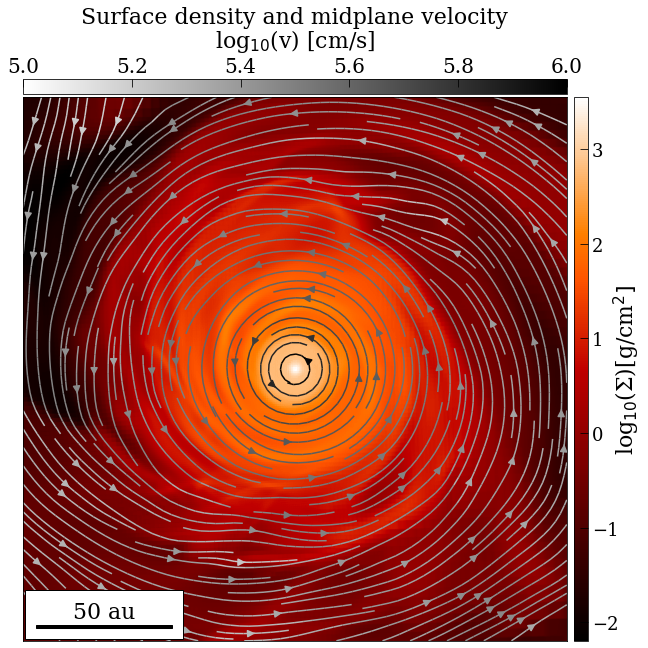

In [14]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])


vmin_strm, vmax_strm = 5, 6

norm = mpl.colors.Normalize(vmin=vmin_strm, vmax=vmax_strm)

cs = axs.imshow(np.log10(Σ), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'gist_heat')
strm  = axs.streamplot(X, Y, vx , vy, color = np.log10(vel_norm), cmap=mpl.cm.binary, arrowsize=1.5, norm = norm, density = 2)

cbaxes_top = fig.add_axes([0.135, 0.885, 0.755, 0.02])  # Position and size adjusted for top placement
cbar_top = fig.colorbar(strm.lines, cax = cbaxes_top, orientation='horizontal')
cbar_top.ax.xaxis.set_ticks_position("top")
cbar_top.set_label('log$_{10}$(v) [cm/s]', labelpad = 10, fontsize=22)
cbar_top.ax.xaxis.set_ticks_position('top')
cbar_top.ax.xaxis.set_label_position('top')


cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('log$_{10}$(Σ)[g/cm$^{2}]$', labelpad = -7, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set_title('Surface density and midplane velocity', fontsize = 22, y=1.125)
cbar.ax.tick_params(labelsize=18)

scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='Black',
                    frameon=True,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)



plt.savefig(save_folder + 'disk_dens', facecolor = 'w', bbox_inches='tight', dpi = 500)


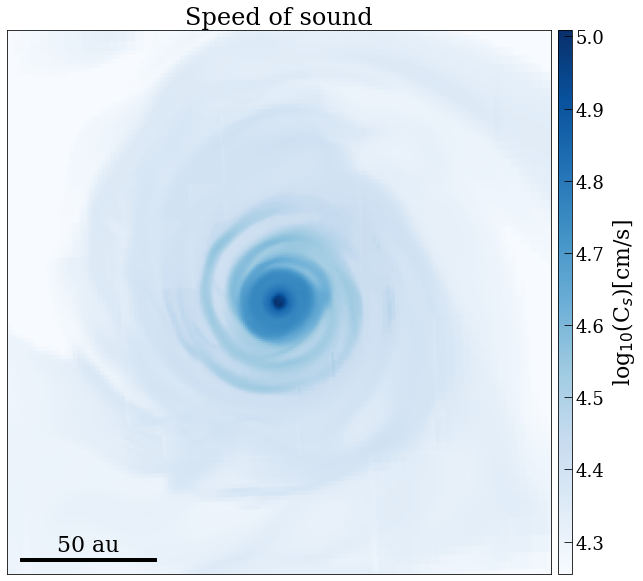

In [15]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])

cs = axs.imshow(np.log10(c_sM), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'Blues')
cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('log$_{10}$(C$_s$)[cm/s]', labelpad = 5, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set_title('Speed of sound')
cbar.ax.tick_params(labelsize=18)

scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='black',
                    frameon=False,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)

plt.savefig(save_folder + 'disk_sounds', facecolor = 'w', bbox_inches='tight', dpi = 500)

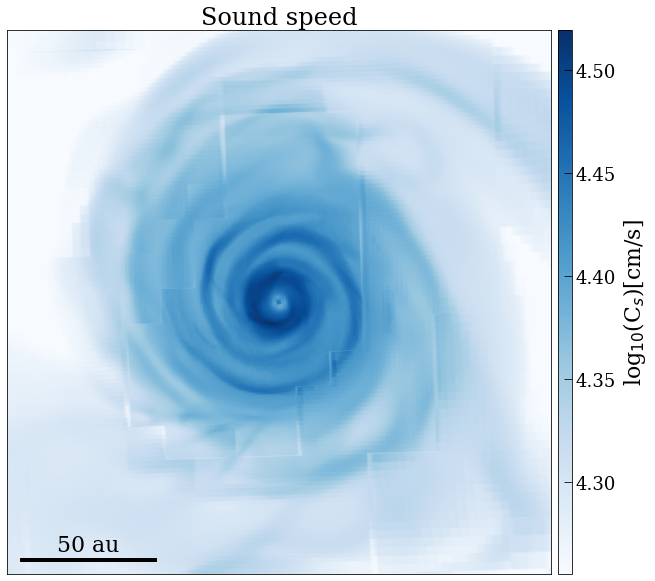

In [16]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])

cs = axs.imshow(np.log10(c_sV), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'Blues')
cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('log$_{10}$(C$_s$)[cm/s]', labelpad = 5, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set(title = 'Sound speed')
cbar.ax.tick_params(labelsize=18)

scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='black',
                    frameon=False,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)

plt.savefig(save_folder + 'disk_sounds', facecolor = 'w', bbox_inches='tight', dpi = 500)

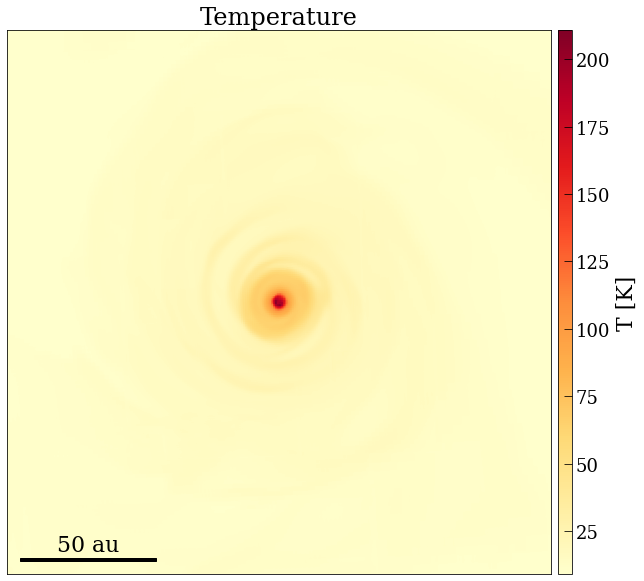

In [17]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])

cs = axs.imshow(T, extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'YlOrRd')
cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('T [K]', labelpad = 5, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set(title = 'Temperature')
cbar.ax.tick_params(labelsize=18)

scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='black',
                    frameon=False,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)

plt.savefig(save_folder + 'disk_temp', facecolor = 'w', bbox_inches='tight', dpi = 500)

### $$ Q = \frac{c_s\Omega}{\pi G\Sigma} \geq 1\;\Rightarrow\; Stable$$

In [18]:
xx, yy = np.meshgrid(X, Y)

In [75]:
Q.min()

1.3004956636011133

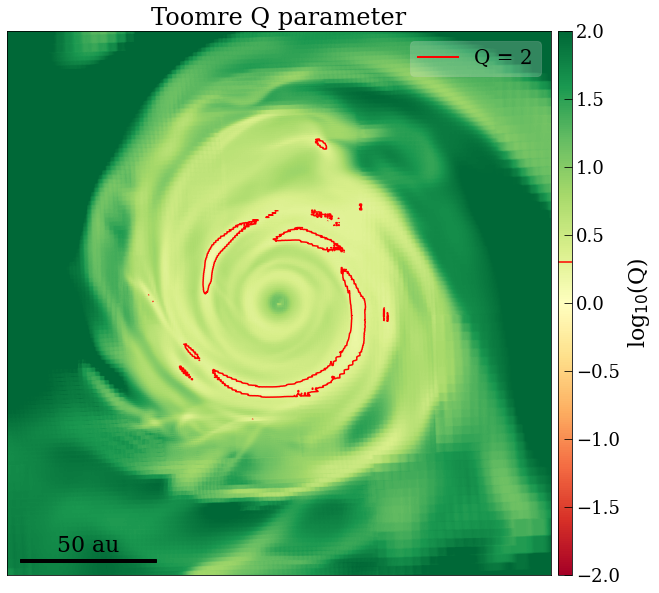

In [19]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])

cs = axs.imshow(np.log10(Q), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'RdYlGn', vmin = -2, vmax = 2)
ct = axs.contour(xx, yy, np.log10(Q), [np.log10(2)], colors = ['red'])


legend_elements = [Line2D([0], [0], color='red', lw=2, ls= '-', label='Q = 2')]
plt.legend(handles = legend_elements, framealpha = 0.2, loc = 'upper right')

contour_labels = []
for i in range(len(contour_labels)):
    ct.collections[i].set_label(contour_labels[i])

cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('log$_{10}$(Q)', labelpad = 5, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set(title = 'Toomre Q parameter')
cbar.ax.tick_params(labelsize=18)
cbar.add_lines(ct)
scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='black',
                    frameon=False,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)
plt.savefig(save_folder + 'disk_toomreq_13_58kyr', facecolor = 'w', bbox_inches='tight', dpi = 500)

In [77]:
data_2 = pipeline(snap = 526, run = 'sink180fmr05', sink_id=178)
data_2.recalc_L()
data_2.calc_trans_xyz()

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4855/4855 [00:32<00:00, 149.44it/s]


Converged mean angular momentum vector after 0 iteration(s)
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4855/4855 [00:01<00:00, 3419.94it/s]


In [78]:
for p in tqdm.tqdm(data_2.sn.patches):
    p.c_s = np.sqrt(p.γ * p.P / p.var('d'))
    p.Ω = p.vφ / p.cyl_R

100%|██████████| 4855/4855 [00:00<00:00, 7046.32it/s]


In [79]:
variable = ['c_s', 'Ω', 'γ']
data_2.to_osyris_ivs(variables=variable, data_name = 'mass_weighted', view = width, resolution=res, weights='mass')

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/2497 [00:00<?, ?it/s]

100%|██████████| 2497/2497 [00:12<00:00, 193.41it/s]


Setting up Osyris data structure


In [80]:
data_2.to_osyris_ivs(variables=['d'], data_name = 'density', view = width, resolution=res, weights=None)

Looping over DISPATCH data to extract data at highest level


100%|██████████| 2497/2497 [00:08<00:00, 284.66it/s]


Setting up Osyris data structure


In [81]:
Σ_2 = data_2.osyris_ivs['density']['d'] * data_2.cgs_density
c_s_2 = data_2.osyris_ivs['mass_weighted']['c_s'] * data_2.cms_velocity
T_2 = c_s**2 * data_2.μ * m_p.to('g').value / ( (data_2.osyris_ivs['mass_weighted']['γ'] * k_B.to('erg/K').value))
Ω_2 = data_2.osyris_ivs['mass_weighted']['Ω'] / data_2.sn.scaling.t


G_cgs = G.to('cm**3 / (g *s**2)').value; print(G_cgs)
Q_2 = (c_s_2 * Ω_2) / (np.pi * G_cgs * Σ_2)


6.674299999999998e-08


In [82]:
Q_2.min()

-1928.3359234908396

In [83]:
100 *0.2

20.0

/tmp/ipykernel_1233855/397087553.py:4: RuntimeWarning: invalid value encountered in log10
  cs = axs.imshow(np.log10(Q_2), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'RdYlGn', vmin = -2, vmax = 2)
/tmp/ipykernel_1233855/397087553.py:5: RuntimeWarning: invalid value encountered in log10
  ct = axs.contour(X, Y, np.log10(Q_2), [np.log10(1), np.log10(2)], colors = ['black', 'red'])


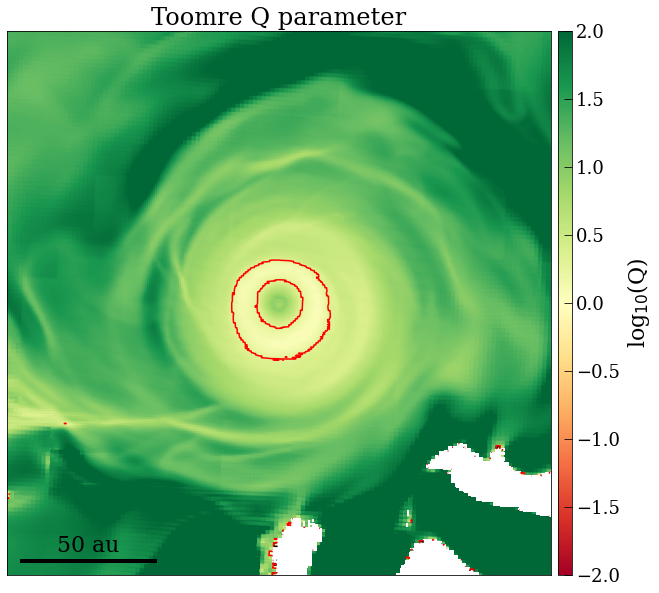

In [84]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set_xticks([]); axs.set_yticks([])

cs = axs.imshow(np.log10(Q_2), extent = (-ext, ext, -ext, ext), origin ='lower', cmap = 'RdYlGn', vmin = -2, vmax = 2)
ct = axs.contour(X, Y, np.log10(Q_2), [np.log10(1), np.log10(2)], colors = ['black', 'red'])
cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cs, cax = cbaxes)
cbar.set_label('log$_{10}$(Q)', labelpad = 5, fontsize = 22)# y = 1.11, rotation = 0, fontsize = 20)

axs.set(title = 'Toomre Q parameter')
cbar.ax.tick_params(labelsize=18)

scalebar = AnchoredSizeBar(axs.transData, 50  , '50 au', 'lower left', 
                    pad=0.5,
                    color='black',
                    frameon=False,
                    fontproperties = fm.FontProperties(size=22),
                    size_vertical=1,
                    label_top=True)

axs.add_artist(scalebar)

#plt.savefig(save_folder + 'disk_toomreq', facecolor = 'w', bbox_inches='tight', dpi = 500)